In [1]:
import os

IMG_PATH = "_img"
CACHE_PATH = "_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

import numpy as np
import scipy.stats as st
import pandas as pd
from tqdm import tqdm
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse
from astroML.utils.decorators import pickle_results

import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

sns.set_theme(context="talk", style="ticks", palette="colorblind", color_codes=True)

from MaStarChecks.io import load_libraries, load_apogee
from MaStarChecks.plotting.analysis import build_comparison_table, consistency_plot, delta_plot, delta_inset_plot, move_legend
from MaStarChecks.plotting.styles import *


PROCESSED_PATH = os.path.join("../fitting/_data", "processed-libraries-v3.1.2")
CLASSIFIED_PATH = "../fitting/_data/classified-mastar-v3.1.2-cleaned-v2-gsl"

LABELS = ("MaStar",)
Y_COLUMNS = ["TEFF", "LOGG", "MET", "ALPHAM"]

def get_range(x, data=None, n=2):
    if data is None:
        xmin, xmax = x.min(), x.max()
    else:
        xmin, xmax = data[x].min(), data[x].max()
    return np.linspace(xmin, xmax, n)

units = dict(zip(Y_COLUMNS, [r"K", r"", r"", r""]))
cols = {label:f"{column}~({unit})" if unit else column for label, column, unit in zip(Y_COLUMNS, [r"$T_\mathrm{eff}$", r"$\log{g}$", r"$[\mathrm{Fe}/\mathrm{H}]$", r"$[\alpha/\mathrm{Fe}]$"], units.values())}

In [2]:
spectra, catalogues = load_libraries(labels=LABELS, kind="classified-gsl",
                                    libraries_path=CLASSIFIED_PATH, use_cache=True,
                                    cache_path=CACHE_PATH, cache_label="model-cleaned-v2-gsl")

spectra_mastar = spectra["MaStar"]["FLUX"]
catalogue_mastar = catalogues["MaStar"]
del spectra, catalogues

catalogue_mastar.rename(columns=cols, inplace=True)
y_cosha = catalogue_mastar.set_index("ID").filter(items=list(cols.values()))

mastar_coords = SkyCoord(ra=catalogue_mastar.RA, dec=catalogue_mastar.DEC, distance=catalogue_mastar.DIST.values*u.kpc)
mastar_R = mastar_coords.galactic.distance.value * np.cos(mastar_coords.galactic.l.value*np.pi/180) + 8
mastar_z = mastar_coords.galactic.distance.value * np.sin(mastar_coords.galactic.b.value*np.pi/180)

Text(0, 0.5, '$z$ (kpc)')

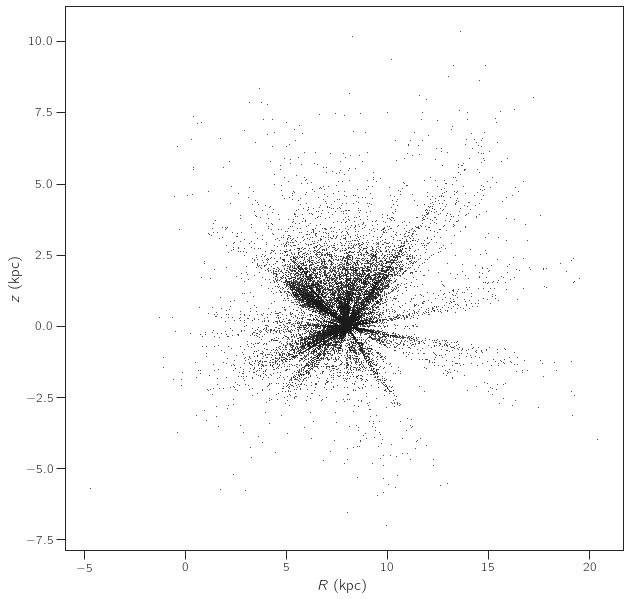

In [3]:
plt.scatter(mastar_R, mastar_z, s=1, lw=0, c="k")
plt.xlabel("$R$ (kpc)")
plt.ylabel("$z$ (kpc)")

In [4]:
APOGEE_DISTANCES_PATH = "_data/apogee-catalogue.csv"
ASPCAP_CATALOGUE_PATH = "_data/APOGEE/allStar-l31c.2.fits"
CANNON_CATALOGUE_PATH = "_data/APOGEE/allStarCannon-l31c.2.fits"


catalogue_aspcap, catalogue_cannon = load_apogee(APOGEE_DISTANCES_PATH, ASPCAP_CATALOGUE_PATH, CANNON_CATALOGUE_PATH)
catalogue_aspcap = catalogue_aspcap.rename(columns=dict(TEFF=cols["TEFF"],LOGG=cols["LOGG"],FE_H=cols["MET"],ALPHA_M=cols["ALPHAM"]))
catalogue_cannon = catalogue_cannon.rename(columns=dict(TEFF=cols["TEFF"],LOGG=cols["LOGG"],FE_H=cols["MET"],ALPHA_M=cols["ALPHAM"]))

apogee_coords = SkyCoord(ra=catalogue_aspcap.RA.values*u.degree, dec=catalogue_aspcap.DEC.values*u.degree, distance=catalogue_aspcap.DIST.values*u.kpc)
apogee_R = apogee_coords.galactic.distance.value * np.cos(apogee_coords.galactic.l.value*np.pi/180) + 8
apogee_z = apogee_coords.galactic.distance.value * np.sin(apogee_coords.galactic.b.value*np.pi/180)

In [5]:
catalogue_aspcap.filter(like="ERR").describe()

TEFF_ERR      LOGG_ERR      FE_H_ERR   ALPHA_M_ERR
count  64747.000000  64747.000000  64747.000000  64747.000000
mean      80.308586      0.055076      0.008333      0.014290
std       15.569267      0.012408      0.001423      0.004466
min       37.195847      0.027220      0.005962      0.006898
25%       70.315895      0.046619      0.007506      0.011732
50%       79.005791      0.054114      0.008088      0.013455
75%       89.099266      0.061848      0.008861      0.015788
max      176.089752      0.183321      0.089961      0.101821

In [6]:
idx, d2d, d3d = match_coordinates_sky(mastar_coords, apogee_coords)
# should be FWHM / 2 ~ 1.25"
mask = d2d.to(u.arcsec)<=1.25*u.arcsec

idx_mastar_match = y_cosha.loc[mask].index
idx_apogee_match = catalogue_aspcap.iloc[idx[mask]].index
# matches = apogee_coords[idx_match]
# print((matches.separation(mastar_coords) == d2d).all(), mask.sum())

y_aspcap_match = catalogue_aspcap.loc[idx_apogee_match].filter(items=cols.values())
y_cosha_match = y_cosha.loc[idx_mastar_match]
y_aspcap_match

$T_\mathrm{eff}$~(K)  $\log{g}$  \
APOGEE_ID                                             
2M23313189+4935523           4792.808105   2.364923   
2M12422797-0303207           5162.209961   3.608670   
2M11555482+1850515           4920.677246   3.308688   
2M11040134+1020062           5197.431641   3.586206   
2M11010999+1214548           5373.003906   2.880688   
...                                  ...        ...   
2M13210208+7318310           4921.256836   3.144945   
2M13225015+7228433           4691.508789   2.422079   
2M13260671+7054586           4598.593750   2.342103   
2M13222192+7259598           4645.901855   2.465976   
2M13340633+7221258           4562.716309   2.741982   

                    $[\mathrm{Fe}/\mathrm{H}]$  $[\alpha/\mathrm{Fe}]$  
APOGEE_ID                                                               
2M23313189+4935523                   -0.140684                0.046911  
2M12422797-0303207                   -0.229621                0.255530  
2M11555482+1850515                   -0.370056                0.224722  
2M11040134+1020062                   -0.677853                0.348473  
2M11010999+1214548                   -1.095227                0.301329  
...                                        ...                     ...  
2M13210208+7318310                   -0.181897                0.083181  
2M13225015+7228433                    0.086560                0.006153  
2M13260671+7054586                   -0.694106                0.251582  
2M13222192+7259598                   -0.380079                0.233504  
2M13340633+7221258                    0.311030                0.056486  

[403 rows x 4 columns]

In [7]:
@pickle_results("_cache/alpha-fe-PDF-estimator.pkl")
def trainPDFestimator(data, x, y, x_err, y_err, n_components=3, max_iter=500):
    
    from MaStarChecks.plotting.analysis import density_scatter_kde, contour_masks
    
    X_alpha = data[[x, y]].values
    pdf_alpha = density_scatter_kde(X_alpha[:,0], X_alpha[:,1])
    z = pdf_alpha(X_alpha[:,0], X_alpha[:,1])

    mask_clean = contour_masks(z, levels=(0.05,)).flatten()
    
    X_alpha = X_alpha[mask_clean]
    X_alpha_err = np.zeros(X_alpha.shape + X_alpha.shape[-1:])
    diag = np.arange(X_alpha.shape[-1])
    X_alpha_err[:, diag, diag] = np.vstack([catalogue_aspcap.loc[mask_clean, x_err] ** 2, catalogue_aspcap.loc[mask_clean, y_err] ** 2]).T

    estimator = XDGMM(n_components, max_iter, verbose=True)    
    estimator.fit(X_alpha, X_alpha_err)
    
#     plt.scatter(X_alpha[:,0], X_alpha[:,1], lw=0, c="k", s=1)
#     colors = ["tab:red", "tab:orange", "tab:blue", "tab:purple"]
#     for i in range(gm.n_components):
#         draw_ellipse(gm.mu[i], gm.V[i], scales=[3], lw=0, fc=colors[i], alpha=0.2)

#     plt.xlabel(cols.get("MET"))
#     plt.ylabel(cols.get("ALPHAM"))
#     plt.xlim(-1.1, 0.6)
#     plt.ylim(-0.1, 0.35)
    
    return estimator

gm = trainPDFestimator(data=catalogue_aspcap, x=cols.get("MET"), y=cols.get("ALPHAM"), x_err="FE_H_ERR", y_err="ALPHA_M_ERR")

@pickle_results: using precomputed results from '_cache/alpha-fe-PDF-estimator.pkl'


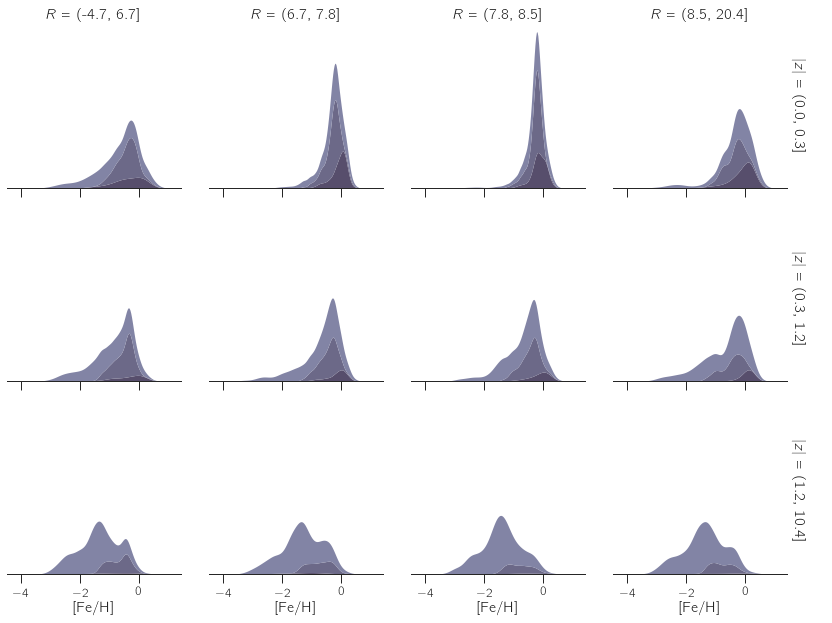

In [8]:
alpha_pdf_labels = [r"Fe-poor~/~$\alpha$-rich", r"Fe-poor~/~$\alpha$-enhanced", r"Fe-rich~/~$\alpha$-solar"]
alpha_rv_components = {}
alpha_rv_components[alpha_pdf_labels[0]] = st.multivariate_normal(gm.mu[0], gm.V[0])
alpha_rv_components[alpha_pdf_labels[1]] = st.multivariate_normal(gm.mu[1], gm.V[1])
alpha_rv_components[alpha_pdf_labels[2]] = st.multivariate_normal(gm.mu[2], gm.V[2])

data = y_cosha.copy()

data["$R$"] = pd.qcut(mastar_R, q=4)
data["$R$"] = data["$R$"].apply(lambda x: pd.Interval(left=round(x.left,1), right=round(x.right,1)))
data["$|z|$"] = pd.qcut(np.abs(mastar_z), q=3)
data["$|z|$"] = data["$|z|$"].apply(lambda x: pd.Interval(left=abs(round(x.left,1)), right=abs(round(x.right,1))))

colors = sns.color_palette(f"blend:{MED_COLOR},{MASTAR_COLOR}", n_colors=3)
pop_order = [r"Fe-poor~/~$\alpha$-enhanced", r"Fe-poor~/~$\alpha$-rich", r"Fe-rich~/~$\alpha$-solar"]

for label in alpha_pdf_labels:
    data[f"PDF({label})"] = alpha_rv_components[label].logpdf(np.dstack((data[cols.get("MET")],data[cols.get("ALPHAM")])))
#     data[r"CDF$_\text{%s}$"%label] = alpha_rv_components[label].cdf(np.dstack((data[cols.get("MET")],data[cols.get("ALPHAM")])))

data["Population"] = data.filter(like="PDF").idxmax(axis="columns").str.replace(r"PDF\(", "").str.strip(r"\)")

g = sns.FacetGrid(data, row="$|z|$", col="$R$", height=3, legend_out=True, margin_titles=True)
g.map(sns.kdeplot, cols.get("MET"),
      hue=data["Population"], hue_order=pop_order,
      multiple="stack", palette=sns.color_palette(f"blend:{MED_COLOR},{MASTAR_COLOR}", n_colors=3), alpha=1)
plt.setp(g.axes, yticklabels=[], yticks=[])
g.despine(left=True)
g.add_legend()
# g.tight_layout()

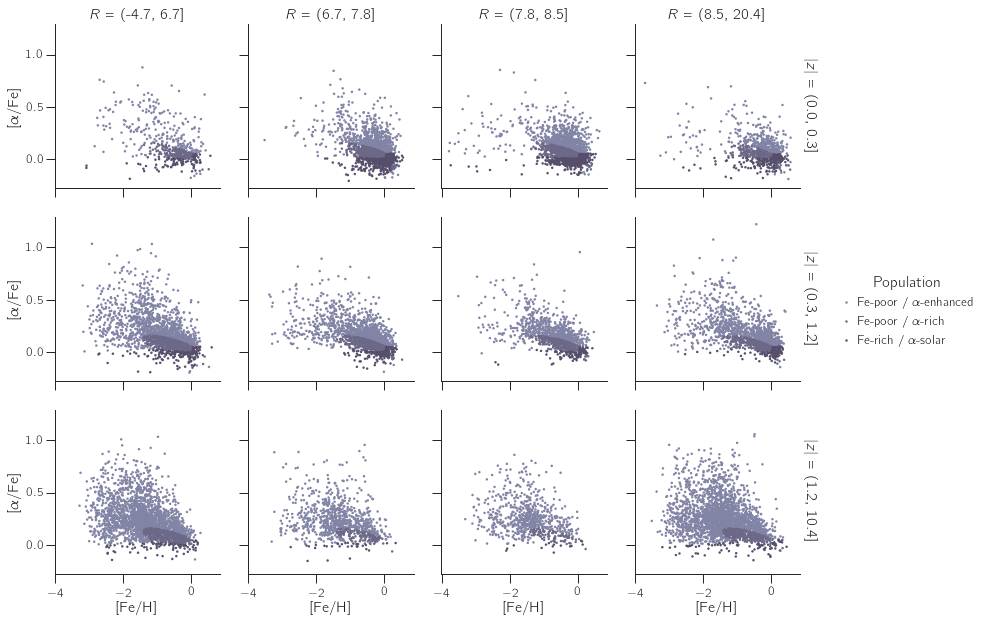

In [9]:
g = sns.FacetGrid(data, row="$|z|$", col="$R$", hue="Population", hue_order=pop_order,
                  palette=sns.color_palette(f"blend:{MED_COLOR},{MASTAR_COLOR}", n_colors=3), height=3, legend_out=True, margin_titles=True)
g.map(sns.scatterplot, cols.get("MET"), cols.get("ALPHAM"), marker=".", size=1, linewidth=0)
# g.map(sns.scatterplot, cols.get("MET"), cols.get("ALPHAM"), )
g.add_legend(adjust_subtitles=True)

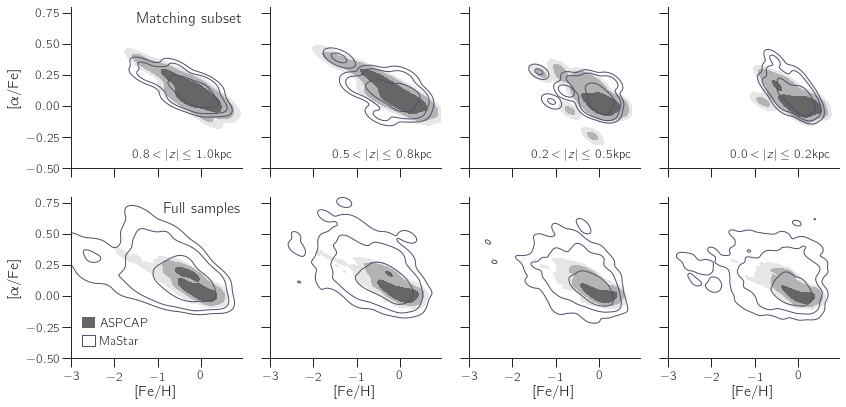

In [10]:
apogee_coords_gal = apogee_coords.galactic[idx[mask]]
apogee_gal_z = np.abs(apogee_coords_gal.distance.value * np.sin(apogee_coords_gal.b.value*np.pi/180))

z_binned = pd.cut(apogee_gal_z, bins=np.linspace(0,1,5), precision=1)
z_bins = z_binned.categories[::-1]

apogee_gal_z = np.abs(apogee_coords.distance.value * np.sin(apogee_coords.galactic.b.value*np.pi/180))
mastar_gal_z = np.abs(mastar_coords.distance.value * np.sin(mastar_coords.galactic.b.value*np.pi/180))

apogee_z_binned = pd.cut(apogee_gal_z, bins=z_bins[::-1], precision=1)
mastar_z_binned = pd.cut(mastar_gal_z, bins=z_bins[::-1], precision=1)

fig, axs = plt.subplots(2, z_bins.size, figsize=(12,6), sharex=True, sharey=True, subplot_kw=dict(xlim=(-3.0,0.95),ylim=(-0.5,0.8)))
for i, z_bin in enumerate(z_bins):
    z_mask = z_binned == z_bin

    sns.kdeplot(data=y_aspcap_match[z_mask], x=cols.get("MET"), y=cols.get("ALPHAM"), levels=(0.01,0.05,0.32,1.00), colors=("0.9","0.7","0.4","0.0"), shade=True, ax=axs[0,i])
    sns.kdeplot(data=y_cosha_match[z_mask], x=cols.get("MET"), y=cols.get("ALPHAM"), levels=(0.01,0.05,0.32,1.00), linewidths=1, colors=MASTAR_COLOR, ax=axs[0,i])
    axs[0,i].text(0.95, 0.05, fr"${z_bin.left}<\left|z\right|\leq{z_bin.right}\,$kpc", va="bottom", ha="right", size="x-small", transform=axs[0,i].transAxes)

    apogee_mask = apogee_z_binned == z_bin
    mastar_mask = mastar_z_binned == z_bin

    sns.kdeplot(data=catalogue_cannon[apogee_mask], x=cols.get("MET"), y=cols.get("ALPHAM"), levels=(0.01,0.05,0.32,1.00), colors=("0.9","0.7","0.4","0.0"), shade=True, ax=axs[1,i])
    sns.kdeplot(data=y_cosha[mastar_mask], weights=catalogue_mastar.set_index("ID").VCORR, x=cols.get("MET"), y=cols.get("ALPHAM"), levels=(0.01,0.05,0.32,1.00), linewidths=1, color=MASTAR_COLOR, ax=axs[1,i])

handles = [mpatches.Patch(facecolor="0.4", label="ASPCAP"),
           mpatches.Patch(facecolor="none", edgecolor=MASTAR_COLOR, lw=1, label="MaStar")]
legend = axs[1,0].legend(handles=handles, loc=3)

sns.despine()
axs[0,0].text(0.95, 0.75, "Matching subset", ha="right", va="top", size="small")
axs[1,0].text(0.95, 0.75, "Full samples", ha="right", va="top", size="small")
fig.tight_layout()
fig.savefig("_img/alpha-fe-aspcap-mastar.png", bbox_inches="tight")